# Cold Face Test – Heart Rate Plots

In [1]:
import json
import re
from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from fau_colors import cmaps, colors_all
import biopsykit as bp
from biopsykit.protocols import MIST
from biopsykit.utils.dataframe_handling import multi_xs

from cft_analysis.datasets import CftDatasetProcessed

from IPython.display import Markdown

%load_ext autoreload
%autoreload 2
%matplotlib widget

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", palette=palette)

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Data Import

In [3]:
# get path to analysis results
base_path = Path("../../data")

In [4]:
results_path = base_path.joinpath("../results")
stats_path = results_path.joinpath("statistics")
plot_path = results_path.joinpath("plots")
bp.utils.file_handling.mkdirs([results_path, stats_path, plot_path])

paper_path = Path("../paper_path.json")
paper_img_path = None
if paper_path.exists():
    paper_path = Path(json.load(paper_path.open(encoding="utf-8"))["paper_path"])
    paper_img_path = paper_path.joinpath("img")
    bp.utils.file_handling.mkdirs([paper_img_path])

In [5]:
hue_order = ["Control", "CFT"]

In [6]:
dataset = CftDatasetProcessed(base_path, exclude_subjects=True)
dataset

,condition,subject,phase,subphase
0,CFT,Vp01,MIST1,AT
1,CFT,Vp01,MIST1,AT
2,CFT,Vp01,MIST1,AT
3,CFT,Vp01,MIST1,AT
4,CFT,Vp01,MIST1,AT
...,...,...,...,...
4443,Control,Vp33,Post,Total
4444,Control,Vp33,Pre,Total
4445,Control,Vp33,Pre,Total
4446,Control,Vp33,Pre,Total


In [7]:
hr_ensemble = dataset.heart_rate_ensemble
hr_mean = dataset.heart_rate
hr_mean = hr_mean.xs("HR_Norm", level="type")
hr_mean.head()

data
condition subject phase subphase category           
CFT       Vp01    MIST1 AT       HR        -4.866102
                        BL       HR        -4.845864
                        FB       HR        -5.795996
                        RP_CFI   HR       -12.341485
                  MIST2 AT       HR        -7.483283

In [8]:
mist = MIST.from_file(base_path.joinpath("mist_cft.json"))
mist

CFT
        Structure: {'Pre': None, 'MIST': {'MIST1': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST2': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST3': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}}, 'Post': None}

In [9]:
mist.add_hr_ensemble("hr_ensemble", {key: val.xs(key) for key, val in hr_ensemble.groupby("phase")})

hr_mean = hr_mean.rename({"RP_CFI": "RP/CFI"}, level="subphase")
mist.add_hr_results("hr_mean", hr_mean)

## HR Ensemble Mean Plot – Combined

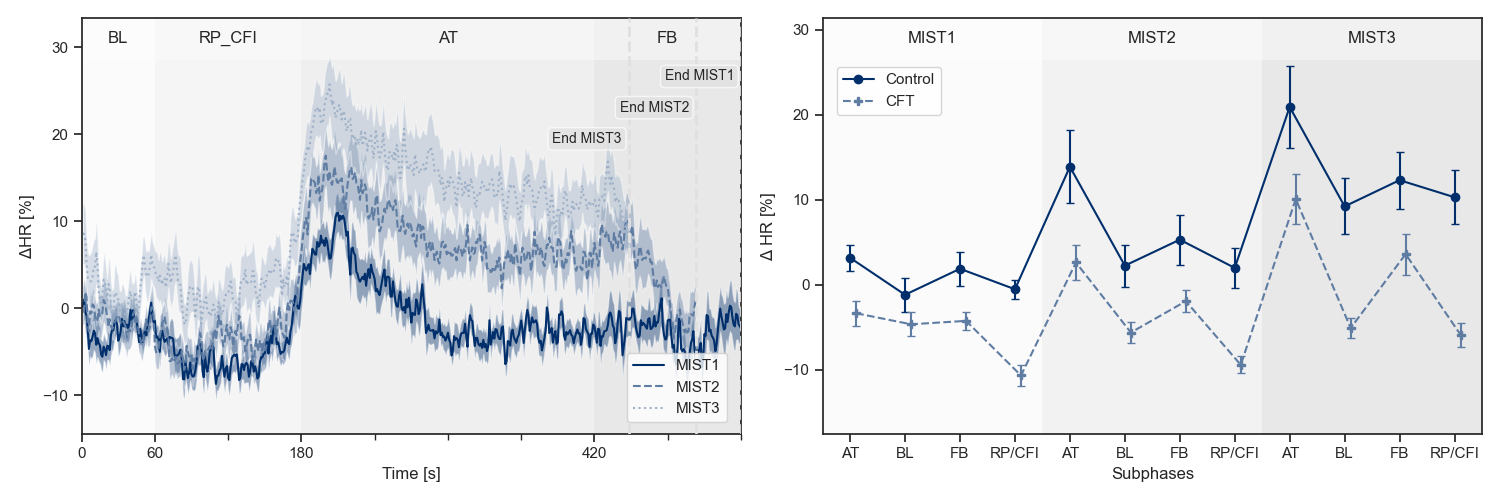

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

# HR Ensemble Plot
mist.hr_ensemble_plot("hr_ensemble", ax=axs[0], palette=sns.color_palette(cmaps.fau))

# HR Mean Plot
mist.hr_mean_plot("hr_mean", is_relative=True, ax=axs[1], order=hue_order, palette=sns.color_palette(cmaps.fau))

for path in [plot_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_hr_mean_ensemble.pdf"), transparent=True)

## HR Ensemble Plot

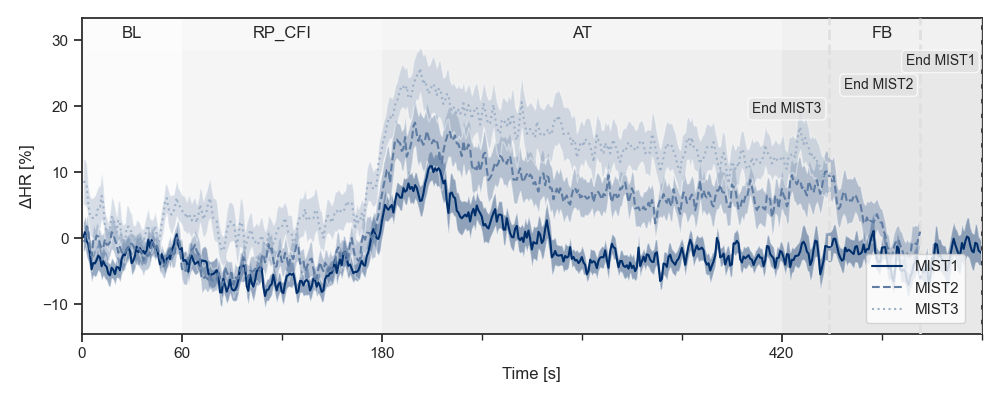

In [11]:
fig, ax = plt.subplots()

# HR Ensemble Plot
mist.hr_ensemble_plot("hr_ensemble", ax=ax)

for path in [plot_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_hr_ensemble.pdf"), transparent=True)

## HR Mean Plot

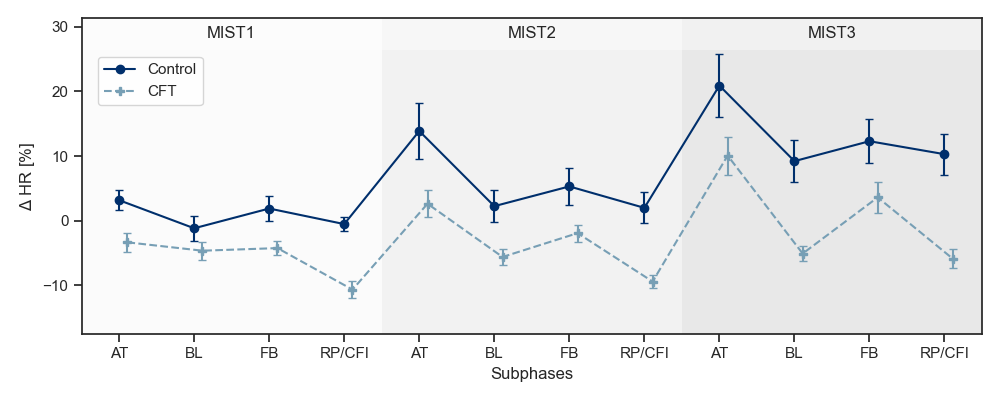

In [18]:
fig, ax = plt.subplots()

# HR Mean Plot
mist.hr_mean_plot("hr_mean", is_relative=True, ax=ax, order=hue_order)

for path in [plot_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_hr_mean_course.pdf"), transparent=True)

## HR Feature Plot

In [13]:
display(Markdown("### Prepare Data"))

phases = ["MIST1", "MIST2", "MIST3"]
subphases = ["BL", "RP_CFI"]
hr_measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
time_bl_measures = ["HR", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(phase=phases, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, hr_measures, level="type")
time_bl_analysis = dataset.get_subset(phase=phases, subphase=subphases).time_above_baseline
time_bl_analysis = multi_xs(time_bl_analysis, time_bl_measures, level="type")

hr_analysis = hr_analysis.unstack(["type", "category"]).join(time_bl_analysis.unstack(["type", "category"]))
hr_analysis = hr_analysis.stack(["category", "type"])
display(hr_analysis.head())


#################################################################
display(Markdown("### Statistics"))

steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "mixed_anova"), ("posthoc", "pairwise_ttests")]
params = {
    "dv": "data",
    "within": "phase",
    "between": "condition",
    "subject": "subject",
    "groupby": ["category", "type", "subphase"],
    "padjust": "bonf",
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.display_results(prep=False, posthoc=False, sig_only=["test", "posthoc"])

### Prepare Data

data
condition subject phase subphase category    type                
CFT       Vp01    MIST1 BL       HR          HR_Norm    -4.845864
                                 HRV         HRV_RMSSD  23.746673
                                             HRV_pNN50   2.173913
                                 Time_BL_Glo HR         22.580645
                                             HRV_RMSSD  69.892473

### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,between,subject,groupby,padjust
parameter,data,phase,condition,subject,"['category', 'type', 'subphase']",bonf


,prep,prep,test,posthoc
parameter,normality,equal_var,mixed_anova,pairwise_ttests


<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

Source            SS  DF1  DF2  \
category    type      subphase                                          
HR          HR_Norm   BL       0    condition   1366.232573    1   23   
                               1        phase    363.805542    2   46   
                               2  Interaction    370.396550    2   46   
                      RP_CFI   0    condition   2956.665859    1   23   
                               1        phase    854.662611    2   46   
Time_BL_Glo HR        BL       0    condition  12251.271574    1   23   
                               1        phase   3819.029296    2   46   
                               2  Interaction   2788.884794    2   46   
                      RP_CFI   0    condition  32257.811328    1   23   
                               1        phase   7808.406424    2   46   
                               2  Interaction   1971.883748    2   46   
            HRV_RMSSD RP_CFI   0    condition  14365.203665    1   23   
            HRV_pNN50 RP_CFI   0    condition  11324.869677    1   23   

                                            MS          F   p-unc       np2  \
category    type      subphase                                                
HR          HR_Norm   BL       0   1366.232573  12.424543  0.0018  0.350733   
                               1    181.902771   6.149889  0.0043  0.210975   
                               2    185.198275   6.261305  0.0039  0.213979   
                      RP_CFI   0   2956.665859  34.069241  0.0000  0.596981   
                               1    427.331306  15.347893  0.0000  0.400228   
Time_BL_Glo HR        BL       0  12251.271574  13.889700  0.0011  0.376520   
                               1   1909.514648   4.756237  0.0133  0.171357   
                               2   1394.442397   3.473291  0.0394  0.131200   
                      RP_CFI   0  32257.811328  76.394880  0.0000  0.768600   
                               1   3904.203212  13.338779  0.0000  0.367067   
                               2    985.941874   3.368488  0.0431  0.127747   
            HRV_RMSSD RP_CFI   0  14365.203665  14.442465  0.0009  0.385724   
            HRV_pNN50 RP_CFI   0  11324.869677   7.674005  0.0109  0.250179   

                                       eps  p-GG-corr sphericity   W-spher  \
category    type      subphase                                               
HR          HR_Norm   BL       0       NaN        NaN        NaN       NaN   
                               1  0.963001        NaN        NaN       NaN   
                               2       NaN        NaN        NaN       NaN   
                      RP_CFI   0       NaN        NaN        NaN       NaN   
                               1  0.776582   0.000076      False  0.712307   
Time_BL_Glo HR        BL       0       NaN        NaN        NaN       NaN   
                               1  0.999155        NaN        NaN       NaN   
                               2       NaN        NaN        NaN       NaN   
                      RP_CFI   0       NaN        NaN        NaN       NaN   
                               1  0.906379        NaN        NaN       NaN   
                               2       NaN        NaN        NaN       NaN   
            HRV_RMSSD RP_CFI   0       NaN        NaN        NaN       NaN   
            HRV_pNN50 RP_CFI   0       NaN        NaN        NaN       NaN   

                                   p-spher  
category    type      subphase              
HR          HR_Norm   BL       0       NaN  
                               1       NaN  
                               2       NaN  
                      RP_CFI   0       NaN  
                               1  0.020215  
Time_BL_Glo HR        BL       0       NaN  
                               1       NaN  
                               2       NaN  
                      RP_CFI   0       NaN  
                               1       NaN  
                               2       NaN  
 

### Boxplots

/var/folders/6b/94ycr58x6416z5qxkbd_548w0000gn/T/ipykernel_15415/3326717777.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=2)


p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

MIST2_Control v.s. MIST2_CFT: Custom statistical test, P_val:3.228e-02
MIST3_Control v.s. MIST3_CFT: Custom statistical test, P_val:2.894e-03
p-value annotation legend:
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

MIST2_Control v.s. MIST2_CFT: Custom statistical test, P_val:3.975e-02
MIST3_Control v.s. MIST3_CFT: Custom statistical test, P_val:6.673e-04


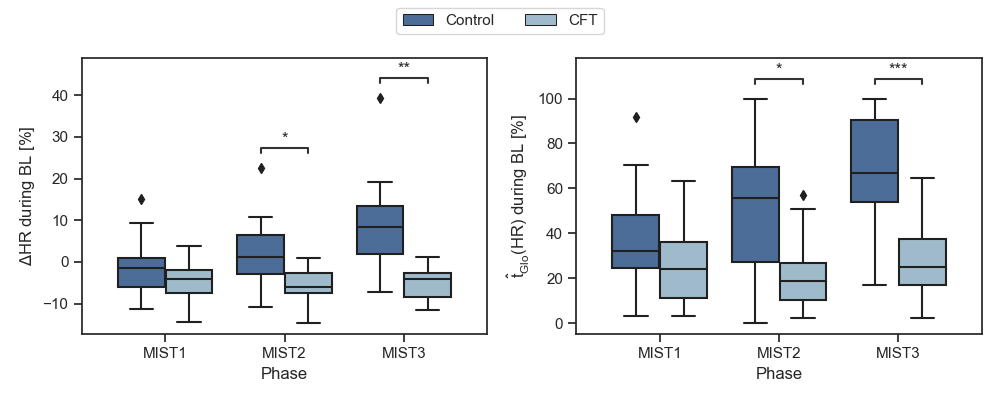

In [31]:
fig, axs = plt.subplots(ncols=2)

category = ["HR"]
feature = ["HR_Norm"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).heart_rate
hr_plot = multi_xs(hr_plot, feature, level="type")

stats_data = stats.results_cat("posthoc").loc[category, feature, subphase]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")


bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues},
    show_legend=False,
    ax=axs[0],
)
axs[0].set_xlabel("Phase")
axs[0].set_ylabel("$\Delta HR$ during $BL$ [%]")

category = ["Time_BL_Glo"]
feature = ["HR"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).time_above_baseline
hr_plot = multi_xs(hr_plot, feature, level="type")


stats_data = stats.results_cat("posthoc").loc[category, feature, subphase, :]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")

bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues},
    legend_loc="upper center",
    legend_orientation="horizontal",
    ax=axs[1],
)


axs[1].set_xlabel("Phase")
axs[1].set_ylabel("$\hat{t}_{Glo}(HR)$ during $BL$ [%]")

axs[0].legend().remove()
axs[1].legend().remove()

fig.tight_layout(rect=(0, 0, 1, 0.9))

for path in [plot_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_boxplot_hr_features.pdf"), transparent=True)